# 🌍 Análise Global de Resíduos Eletrônicos (E-Waste)
Este notebook apresenta uma análise da geração, reciclagem e impacto ambiental/financeiro dos resíduos eletrônicos com base no relatório Global E-Waste Monitor 2024.

In [7]:
# Importacao de bibliotecas
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm import create_model
from sklearn.metrics import classification_report
import time
import matplotlib.pyplot as plt

# Categorização das Imagens

In [ ]:
#from google.colab import drive
#import os

# 1. Montar o Google Drive
#drive.mount('/content/drive')
#print("✅ Google Drive montado!")

# 2. Caminho raiz da pasta que deseja processar
#base_dir = input("📁 Caminho da pasta (ex: /content/drive/MyDrive/Datasets/imagens_placas/Notebook): ").strip()

# 3. Extensões válidas
#EXTENSOES_VALIDAS = ('.jpg', '.jpeg', '.png')

# 4. Função para renomear arquivos em uma pasta
#def renomear_em_pasta(pasta_path, prefixo):
#    arquivos = sorted([
#        f for f in os.listdir(pasta_path)
#        if f.lower().endswith(EXTENSOES_VALIDAS)
#    ])
#    for idx, nome_antigo in enumerate(arquivos, start=1):
#        extensao = os.path.splitext(nome_antigo)[1].lower()
#        novo_nome = f"{prefixo}{idx:02}{extensao}"
#        caminho_antigo = os.path.join(pasta_path, nome_antigo)
#        caminho_novo = os.path.join(pasta_path, novo_nome)
#        try:
#            os.rename(caminho_antigo, caminho_novo)
#            print(f"[✓] {caminho_antigo} → {novo_nome}")
#        except Exception as e:
#            print(f"[!] Erro ao renomear {nome_antigo}: {e}")

# 5. Percorrer recursivamente a pasta
#for root, dirs, files in os.walk(base_dir):
#    if not files:
#        continue  # pula pastas vazias
#
#    # Pega o nome da última pasta como prefixo
#    nome_pasta = os.path.basename(root).lower()
#    print(f"\n📂 Processando pasta: {root} | Prefixo: {nome_pasta}")
#    renomear_em_pasta(root, nome_pasta)




# Data Augmentation

In [ ]:
#import os
#import random
#from PIL import Image
#from torchvision import transforms
#from tqdm import tqdm

# Caminhos
#INPUT_DIR = "/content/drive/MyDrive/Datasets/imagens_placas"               # Pasta original com subpastas por categoria
#OUTPUT_DIR = "/content/drive/MyDrive/Datasets/imagens_placas_augmented"     # Onde salvar as imagens aumentadas
#NUM_AUGS = 100                        # Número de aumentos por imagem
#TARGET_SIZE = (224, 224)             # Tamanho padrão para ViT

# Transformações variadas
#base_transforms = [
#    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.05),
#    transforms.RandomHorizontalFlip(),
#    transforms.RandomVerticalFlip(),
#    transforms.RandomRotation(degrees=25),
#    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
#    transforms.RandomPerspective(distortion_scale=0.4, p=0.5),
#    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
#    transforms.RandomResizedCrop(size=TARGET_SIZE, scale=(0.7, 1.0))
#]

#def get_random_augmentation():
#    return transforms.Compose([
#        transforms.Resize(TARGET_SIZE),
#        transforms.RandomApply([random.choice(base_transforms)], p=0.9),
#        transforms.ToTensor(),
#        transforms.ToPILImage()
#    ])

# Processamento por categoria
#for class_name in os.listdir(INPUT_DIR):
#    input_class_dir = os.path.join(INPUT_DIR, class_name)
#    output_class_dir = os.path.join(OUTPUT_DIR, class_name)
#    os.makedirs(output_class_dir, exist_ok=True)
#
#    for img_name in tqdm(os.listdir(input_class_dir), desc=f"Classe {class_name}"):
#        input_path = os.path.join(input_class_dir, img_name)

#        try:
#            image = Image.open(input_path).convert("RGB")
#        except Exception as e:
#            print(f"[!] Erro ao abrir {input_path}: {e}")
#            continue

        # Remove extensão e cria nome base
#        base_name = os.path.splitext(img_name)[0]
#
#        for i in range(1, NUM_AUGS + 1):
#            aug = get_random_augmentation()
#            augmented_img = aug(image)

#            new_filename = f"{base_name}_aug{i:03}.jpg"
#            new_path = os.path.join(output_class_dir, new_filename)
#            augmented_img.save(new_path)


# Montagem do modelo e hiperparametros

In [8]:
# Diretório do dataset
DATASET_PATH = "/Users/wfleandro/Documents/FEI/CienciaDeDados/imagens_placas_augmented"

In [11]:
# Hiperparâmetros
BATCH_SIZE = 16
NUM_EPOCHS = 10
LR = 1e-4
IMAGE_SIZE = 224
#DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(DEVICE)

mps


In [20]:
# Transformações de imagem (ViT requer normalização específica)
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [18]:
import os
from torchvision import datasets

# Garante que apenas subpastas válidas com imagens sejam consideradas
def limpar_pastas_invalidas(dataset_path):
    for nome in os.listdir(dataset_path):
        caminho = os.path.join(dataset_path, nome)
        if not os.path.isdir(caminho):
            continue
        if not any(fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')) for fname in os.listdir(caminho)):
            print(f"Removendo pasta inválida: {caminho}")
            os.rmdir(caminho)

# Caminho correto
DATASET_PATH = "/Users/wfleandro/Documents/FEI/CienciaDeDados/imagens_placas_augmented"

# Executa limpeza
limpar_pastas_invalidas(DATASET_PATH)

# Carrega o dataset agora limpo
dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)
class_names = dataset.classes
NUM_CLASSES = len(class_names)

print(f"✅ Dataset com {NUM_CLASSES} classes: {class_names}")


Removendo pasta inválida: /Users/wfleandro/Documents/FEI/CienciaDeDados/imagens_placas_augmented/.DS_Store
✅ Dataset com 17 classes: ['CPU', 'Celulares', 'Computador', 'Hard disk', 'Memoria Notebook', 'Motherboard', 'Motherboard Notebooks', 'Notebook', 'PLACA CONECTOR BACKPLANE', 'PLACA DE CELULAR COM COMPONENTES', 'PLACA DE TELEFONIA', 'PROCESSADOR CERÂMICO', 'PROCESSADOR PLÁSTICO', 'Pente de Memoria', 'Placa de Video', 'Teclados', 'mouse']


In [ ]:
# Dataset: assume subpastas por classe
#dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)
#class_names = dataset.classes
#NUM_CLASSES = len(class_names)

In [21]:
print(f"Dataset carregado com {len(dataset)} imagens. Classes: {class_names}")

Dataset carregado com 94200 imagens. Classes: ['CPU', 'Celulares', 'Computador', 'Hard disk', 'Memoria Notebook', 'Motherboard', 'Motherboard Notebooks', 'Notebook', 'PLACA CONECTOR BACKPLANE', 'PLACA DE CELULAR COM COMPONENTES', 'PLACA DE TELEFONIA', 'PROCESSADOR CERÂMICO', 'PROCESSADOR PLÁSTICO', 'Pente de Memoria', 'Placa de Video', 'Teclados', 'mouse']


In [22]:
# Divisão treino/validação (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)


In [23]:
# Modelo ViT ou DeiT (usando timm)
model = create_model('vit_base_patch16_224', pretrained=True, num_classes=NUM_CLASSES)
model = model.to(DEVICE)

In [25]:

import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

# Modelo com Dropout (exemplo com ViT ou similar)
# model = create_model('vit_base_patch16_224', pretrained=True, num_classes=NUM_CLASSES, drop_rate=0.3)
# Se você estiver usando outro modelo, inclua dropout manualmente

# Otimizador com Weight Decay
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

# Agendadores de taxa de aprendizado
scheduler_cosine = CosineAnnealingLR(optimizer, T_max=10)
scheduler_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Early Stopping
early_stop_patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validação
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"[{epoch+1}/{NUM_EPOCHS}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Atualização dos schedulers
    scheduler_cosine.step()
    scheduler_plateau.step(val_loss)

    # Verificação de early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_wts = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print(f"🛑 Early stopping ativado na época {epoch+1}")
            break

# Restaurar melhor modelo
model.load_state_dict(best_model_wts)


[1/10] Train Loss: 0.0827 | Val Loss: 0.1193
[2/10] Train Loss: 0.0492 | Val Loss: 0.0200
[3/10] Train Loss: 0.0348 | Val Loss: 0.0549
[4/10] Train Loss: 0.0277 | Val Loss: 0.0173
[5/10] Train Loss: 0.0199 | Val Loss: 0.0329
[6/10] Train Loss: 0.0155 | Val Loss: 0.0116
[7/10] Train Loss: 0.0116 | Val Loss: 0.0094
[8/10] Train Loss: 0.0095 | Val Loss: 0.0104
[9/10] Train Loss: 0.0086 | Val Loss: 0.0111
[10/10] Train Loss: 0.0076 | Val Loss: 0.0122


<All keys matched successfully>

# Gráfico de Evolução da Aprendizagem

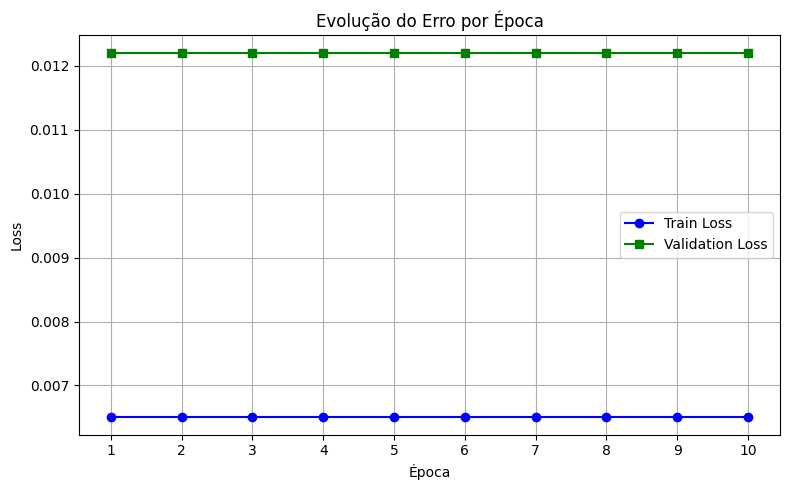

In [32]:
import matplotlib.pyplot as plt

# Plotando train_loss e val_loss separadamente
plt.figure(figsize=(8, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label="Train Loss", marker='o', color='blue')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label="Validation Loss", marker='s', color='green')
plt.title("Evolução do Erro por Época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.xticks(range(1, NUM_EPOCHS + 1))
plt.tight_layout()
plt.show()



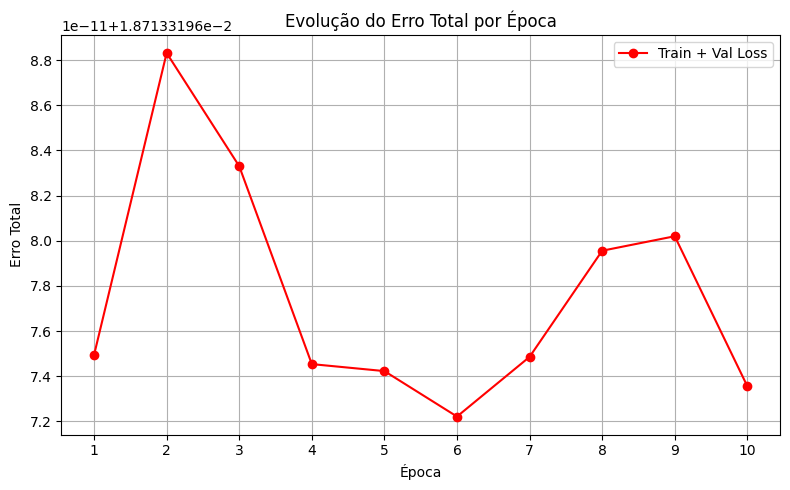

In [33]:
# Cálculo do erro total por época
erro_total = [t + v for t, v in zip(train_losses, val_losses)]

# Plot do erro total
plt.figure(figsize=(8, 5))
plt.plot(range(1, NUM_EPOCHS + 1), erro_total, marker='o', color='red', label='Train + Val Loss')
plt.title("Evolução do Erro Total por Época")
plt.xlabel("Época")
plt.ylabel("Erro Total")
plt.grid(True)
plt.xticks(range(1, NUM_EPOCHS + 1))
plt.legend()
plt.tight_layout()
plt.show()


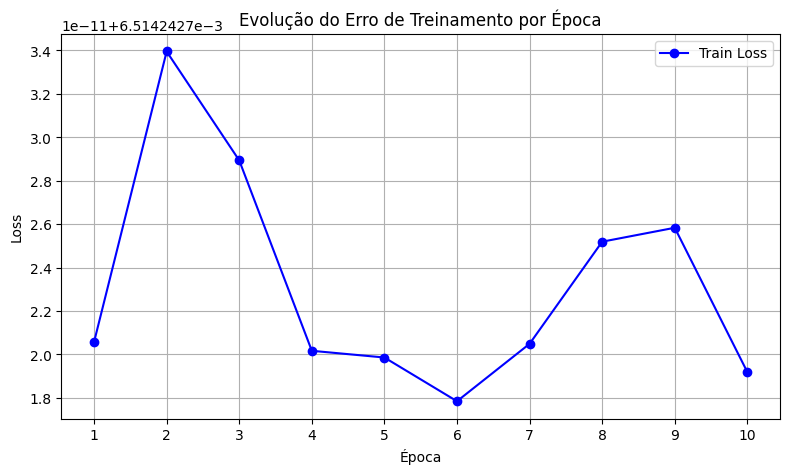

In [ ]:
import matplotlib.pyplot as plt

# Plot da perda de treinamento por época
plt.figure(figsize=(8, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, marker='o', color='blue', label='Train Loss')
plt.title("Evolução do Erro de Treinamento por Época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.xticks(range(1, NUM_EPOCHS + 1))
plt.legend()
plt.tight_layout()
plt.show()


# Validação do modelo

In [28]:
# Validação final
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels.tolist())

print("\n📊 Relatório de classificação:")
print(classification_report(all_labels, all_preds, target_names=class_names))


📊 Relatório de classificação:
                                  precision    recall  f1-score   support

                             CPU       1.00      1.00      1.00       393
                       Celulares       1.00      1.00      1.00      4441
                      Computador       1.00      1.00      1.00       550
                       Hard disk       1.00      1.00      1.00      1843
                Memoria Notebook       1.00      1.00      1.00       147
                     Motherboard       1.00      1.00      1.00      2116
           Motherboard Notebooks       1.00      1.00      1.00       488
                        Notebook       1.00      1.00      1.00      3731
        PLACA CONECTOR BACKPLANE       1.00      1.00      1.00       498
PLACA DE CELULAR COM COMPONENTES       0.90      0.89      0.89       386
              PLACA DE TELEFONIA       0.87      0.88      0.88       325
           PROCESSADOR CERÂMICO       0.90      0.87      0.88       178
      

In [ ]:
# Salvar modelo
torch.save(model.state_dict(), "vit_classificador.pth")
print("✅ Modelo salvo como vit_classificador.pth")

[1/10] Train Loss: 0.0065, Val Loss: 0.0122, Val Accuracy: 0.9934
[2/10] Train Loss: 0.0065, Val Loss: 0.0122, Val Accuracy: 0.9934
[3/10] Train Loss: 0.0065, Val Loss: 0.0122, Val Accuracy: 0.9934
[4/10] Train Loss: 0.0065, Val Loss: 0.0122, Val Accuracy: 0.9934
[5/10] Train Loss: 0.0065, Val Loss: 0.0122, Val Accuracy: 0.9934
[6/10] Train Loss: 0.0065, Val Loss: 0.0122, Val Accuracy: 0.9934
[7/10] Train Loss: 0.0065, Val Loss: 0.0122, Val Accuracy: 0.9934
[8/10] Train Loss: 0.0065, Val Loss: 0.0122, Val Accuracy: 0.9934
[9/10] Train Loss: 0.0065, Val Loss: 0.0122, Val Accuracy: 0.9934
[10/10] Train Loss: 0.0065, Val Loss: 0.0122, Val Accuracy: 0.9934


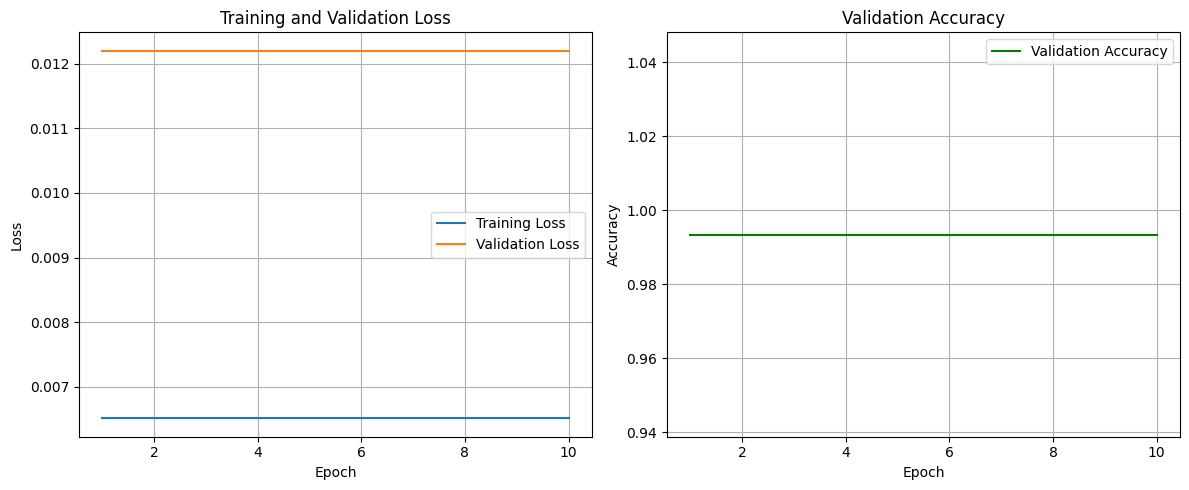


📊 Relatório de classificação:
                                  precision    recall  f1-score   support

                             CPU       1.00      1.00      1.00       393
                       Celulares       1.00      1.00      1.00      4441
                      Computador       1.00      1.00      1.00       550
                       Hard disk       1.00      1.00      1.00      1843
                Memoria Notebook       1.00      1.00      1.00       147
                     Motherboard       1.00      1.00      1.00      2116
           Motherboard Notebooks       1.00      1.00      1.00       488
                        Notebook       1.00      1.00      1.00      3731
        PLACA CONECTOR BACKPLANE       1.00      1.00      1.00       498
PLACA DE CELULAR COM COMPONENTES       0.90      0.89      0.89       386
              PLACA DE TELEFONIA       0.87      0.88      0.88       325
           PROCESSADOR CERÂMICO       0.90      0.87      0.88       178
      

In [29]:
# prompt: Gere o grafico de train e validação

import matplotlib.pyplot as plt
import numpy as np

# Listas para armazenar os resultados do treinamento e validação
train_losses = []
val_losses = []
val_accuracies = []

# Adicionar loop de validação dentro do loop de epochs
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validação
    model.eval()
    total_val_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_predictions / total_samples

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"[{epoch+1}/{NUM_EPOCHS}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


# Gerar gráficos
epochs_range = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfico de Acurácia (Opcional, mas útil)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Validação final (manter o relatório de classificação)
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels.tolist())

print("\n📊 Relatório de classificação:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Salvar modelo
torch.save(model.state_dict(), "vit_classificador.pth")
print("✅ Modelo salvo como vit_classificador.pth")


# Inferência do Modelo

In [42]:
from PIL import Image
model.eval()

def prever_imagem(caminho_img):
    img = Image.open(caminho_img).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(img_tensor)
        pred = torch.argmax(output, dim=1).item()
        return class_names[pred]

# Exemplo:
print(prever_imagem("/Users/wfleandro/Documents/FEI/CienciaDeDados/processador_amd_ryzen_5_4600g_3_7ghz_4_2ghz_max_turbo_cache_11mb_am4_video_integrado_box_8179_3_aee9ea65842dc1445e841d0863696f8b.webp"))


Notebook
